# Anggota:
- Jason Natanael Krisyanto (140810220051)
- Fahri Nizar Argubi (140810220054)
- Muhammad Nabil Indiharto (140810220067)

In [ ]:
# Install dependencies from requirements.txt
!pip install -r requirements.txt

# Import Dataset

In [84]:
import pandas as pd

import kagglehub

# download dataset kaggle
path = kagglehub.dataset_download("robikscube/eye-state-classification-eeg-dataset")

print("Path to dataset files:", path)

# load dataset
df = pd.read_csv(f"{path}/EEG_Eye_State_Classification.csv")

# pisahkan berdasarkan nilai eyeDetection
df_eye0 = df[df["eyeDetection"] == 0]
df_eye1 = df[df["eyeDetection"] == 1]

Using Colab cache for faster access to the 'eye-state-classification-eeg-dataset' dataset.
Path to dataset files: /kaggle/input/eye-state-classification-eeg-dataset


<h1 style="background-color:#1C64BE; color:white; padding:12px 16px; border-radius:6px;">
Tahap 1: Persiapan dan Pemahaman Dataset
</h1>

In [85]:
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nData Types:\n", df.dtypes)
print("\nSummary Statistics:\n", df.describe())

Dataset Shape: (14980, 15)

Columns: ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4', 'eyeDetection']

Data Types:
 AF3             float64
F7              float64
F3              float64
FC5             float64
T7              float64
P7              float64
O1              float64
O2              float64
P8              float64
T8              float64
FC6             float64
F4              float64
F8              float64
AF4             float64
eyeDetection      int64
dtype: object

Summary Statistics:
                  AF3            F7            F3            FC5            T7  \
count   14980.000000  14980.000000  14980.000000   14980.000000  14980.000000   
mean     4321.917777   4009.767694   4264.022433    4164.946326   4341.741075   
std      2492.072174     45.941672     44.428052    5216.404632     34.738821   
min      1030.770000   2830.770000   1040.000000    2453.330000   2089.740000   
25%      4280.510000   3990.770000   4250.2

### Check Missing Values

In [86]:
print(df.isnull().sum())

AF3             0
F7              0
F3              0
FC5             0
T7              0
P7              0
O1              0
O2              0
P8              0
T8              0
FC6             0
F4              0
F8              0
AF4             0
eyeDetection    0
dtype: int64


### Check Distribusi Label Kelas

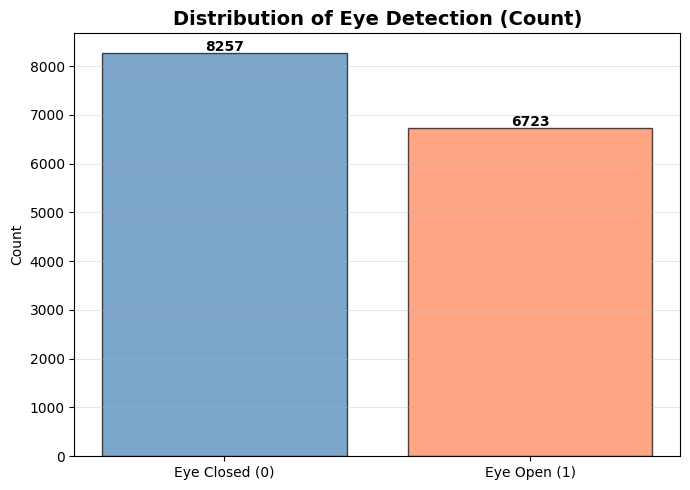

In [87]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 1, figsize=(7, 5))

# buat grafik class
eye_counts = df["eyeDetection"].value_counts().sort_index()
axes.bar(['Eye Closed (0)', 'Eye Open (1)'], eye_counts.values, color=['steelblue', 'coral'], alpha=0.7, edgecolor='black')
axes.set_title('Distribution of Eye Detection (Count)', fontsize=14, fontweight='bold')
axes.set_ylabel('Count')
axes.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(eye_counts.values):
    axes.text(i, v + 50, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

### Menghitung Sampling Rate

In [88]:
# hitung sampling rate (Hz) dari jumlah sampel dan durasi rekaman
duration_sec = 117 # 117 berdasarkan informasi lama perekaman dari dataset kaggle
fs = len(df) / duration_sec

print(f"Sampling rate: {fs:.2f} Hz")

Sampling rate: 128.03 Hz


### Visualisasi Data

In [89]:
import plotly.graph_objects as go

eeg0 = df_eye0.drop(columns=["eyeDetection"]).iloc[:100]
eeg_cols = eeg0.columns.tolist()

fig = go.Figure()
for col in eeg_cols:
    fig.add_trace(go.Scatter(y=eeg0[col].values, mode='lines', name=col, opacity=0.7))

fig.update_layout(
    title="Waveforms (First 100 rows)",
    xaxis_title="Time (samples)", yaxis_title="Amplitude",
    hovermode='x unified', height=600, template='plotly_white'
)

fig.show()

### Visualisasi dengan library mne

Creating RawArray with float64 data, n_channels=14, n_times=8257
    Range : 0 ... 8256 =      0.000 ...    64.483 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=6723
    Range : 0 ... 6722 =      0.000 ...    52.502 secs
Ready.
EEG EYE CLOSED


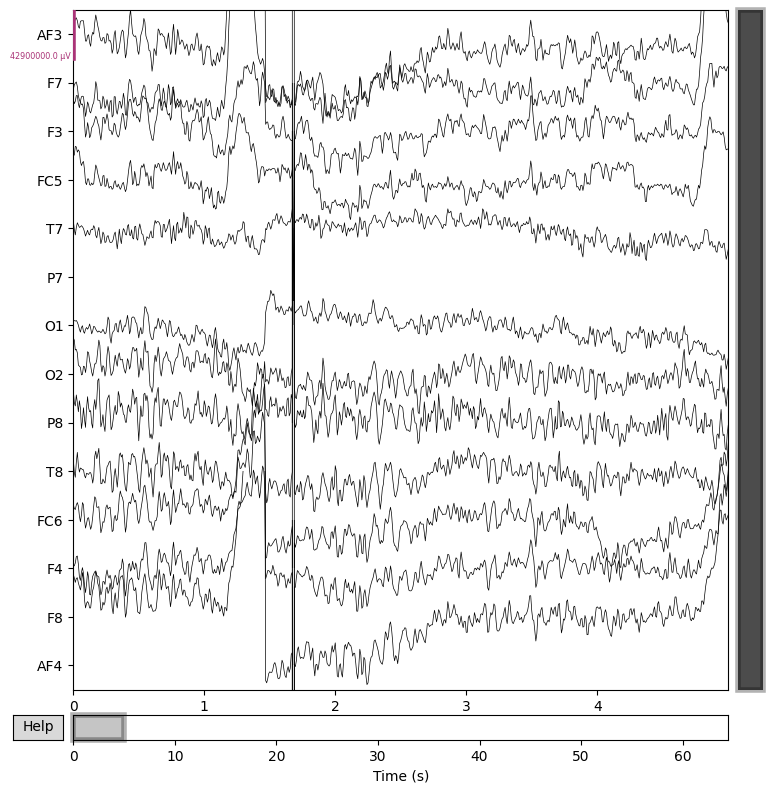


EEG EYE OPEN


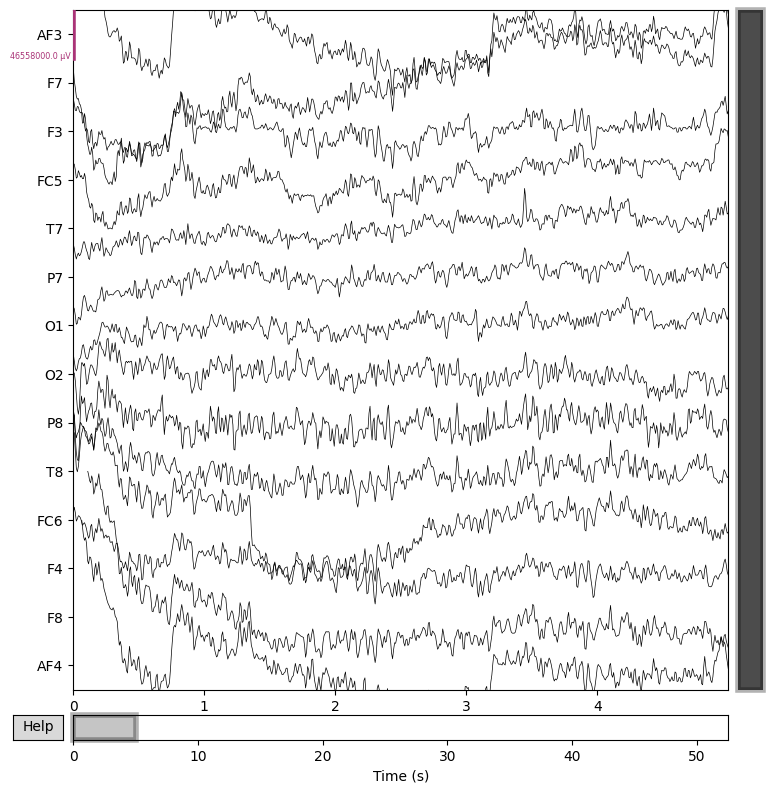

In [90]:
import mne

eeg_cols = [c for c in df_eye0.columns if c != 'eyeDetection']

data_eye0 = df_eye0[eeg_cols].values.T
data_eye1 = df_eye1[eeg_cols].values.T

sfreq = fs

info = mne.create_info(
    ch_names=eeg_cols,
    sfreq=sfreq,
    ch_types='eeg'
)

raw_eye0 = mne.io.RawArray(data_eye0, info)
raw_eye1 = mne.io.RawArray(data_eye1, info)

print("="*50)
print("EEG EYE CLOSED")
print("="*50)

_ = raw_eye0.plot(
    duration=5,
    n_channels=len(eeg_cols),
    scalings='auto',
    title='EEG - Eye Closed (Raw)'
)

print("\n" + "="*50)
print("EEG EYE OPEN")
print("="*50)

_ = raw_eye1.plot(
    duration=5,
    n_channels=len(eeg_cols),
    scalings='auto',
    title='EEG - Eye Open (Raw)'
)



<h1 style="background-color:#1C64BE; color:white; padding:12px 16px; border-radius:6px;">
Tahap 2: Preprocessing Sinyal
</h1>

### Filtering: Bandpass Filter

In [91]:
from scipy.signal import butter, filtfilt

def bandpass_filter(data, lowcut=0.5, highcut=45.0, fs=128, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    return filtfilt(b, a, data)

def preprocess_eeg(df, fs):
    df = df.copy()
    eeg_cols = df.columns.drop("eyeDetection")

    for col in eeg_cols:
        df[col] = bandpass_filter(
            df[col].values,
            lowcut=0.5,
            highcut=45,
            fs=fs,
            order=5
        )
    return df

df_eye0_filt = preprocess_eeg(df_eye0, fs)
df_eye1_filt = preprocess_eeg(df_eye1, fs)

### Segmentasi (Epoching)

In [92]:
epoch_duration = 1       # detik
samples_per_epoch = int(fs * epoch_duration)    # ≈128 sampel
import numpy as np

def epoch_signal(df, fs, epoch_duration=1):
    eeg_cols = df.columns.drop("eyeDetection")
    samples_per_epoch = int(fs * epoch_duration)

    data = df[eeg_cols].values
    labels = df["eyeDetection"].values

    total_samples = len(df)
    total_epochs = total_samples // samples_per_epoch

    X_epochs = []
    y_epochs = []

    for i in range(total_epochs):
        start = i * samples_per_epoch
        end   = start + samples_per_epoch

        epoch_data = data[start:end]

        # skip kalau panjang epoch kurang (sisa)
        if len(epoch_data) != samples_per_epoch:
            continue

        X_epochs.append(epoch_data)

        # label epoch = mayoritas label di segment tersebut
        epoch_label = np.round(np.mean(labels[start:end]))
        y_epochs.append(epoch_label)

    return np.array(X_epochs), np.array(y_epochs)

X0, y0 = epoch_signal(df_eye0_filt, fs=fs, epoch_duration=epoch_duration)

print("Shape X:", X0.shape)
print("Shape y:", y0.shape)

X1, y1 = epoch_signal(df_eye1_filt, fs=fs, epoch_duration=epoch_duration)

print("Shape X:", X1.shape)
print("Shape y:", y1.shape)

Shape X: (64, 128, 14)
Shape y: (64,)
Shape X: (52, 128, 14)
Shape y: (52,)


### Normalisasi

In [93]:
from sklearn.preprocessing import StandardScaler
import numpy as np

def normalize_epochs(X):
    """
    X shape: (n_epochs, n_samples, n_channels)
    Normalisasi Z-score per channel.
    """
    n_epochs, n_samples, n_channels = X.shape
    X_norm = np.zeros_like(X)

    for ch in range(n_channels):
        scaler = StandardScaler()
        # Reshape jadi (n_epochs*n_samples, 1)
        data_ch = X[:, :, ch].reshape(-1, 1)
        data_ch = scaler.fit_transform(data_ch)
        # Balikkan lagi ke bentuk (epochs, samples)
        X_norm[:, :, ch] = data_ch.reshape(n_epochs, n_samples)

    return X_norm

# Normalisasi
X0_norm = normalize_epochs(X0)
X1_norm = normalize_epochs(X1)

print("X0_norm:", X0_norm.shape)
print("X1_norm:", X1_norm.shape)

X0_norm: (64, 128, 14)
X1_norm: (52, 128, 14)


### Visualisasi perbandingan sebelum dan setelah proses preprocessing

Creating RawArray with float64 data, n_channels=14, n_times=8192
    Range : 0 ... 8191 =      0.000 ...    63.975 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=8192
    Range : 0 ... 8191 =      0.000 ...    63.975 secs
Ready.
Effective window size : 15.996 (s)
Plotting power spectral density (dB=True).
Effective window size : 15.996 (s)
Plotting power spectral density (dB=True).


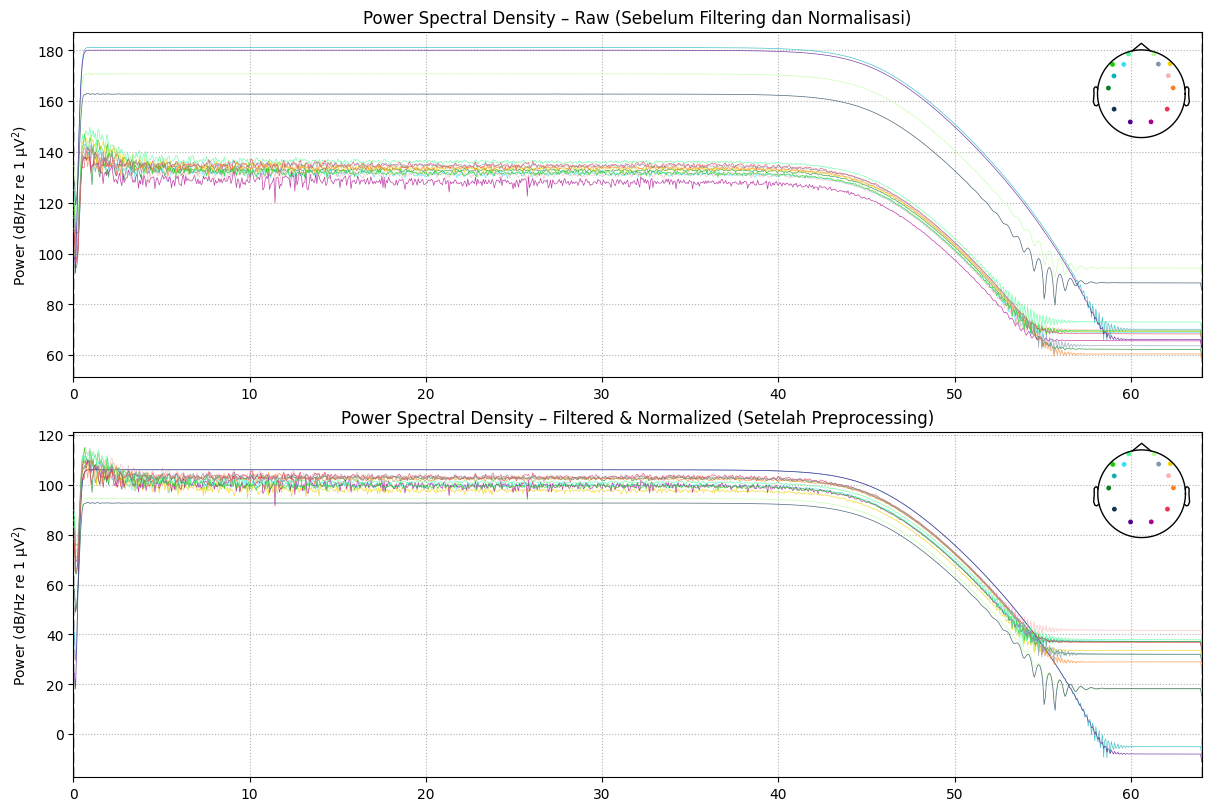

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import mne

# Buat MNE RawArray untuk data sebelum normalisasi (raw)
eeg_cols = [c for c in df.columns if c != 'eyeDetection']
sfreq = fs

# Data raw (sebelum normalisasi)
X0_raw_flat = X0.reshape(X0.shape[0] * X0.shape[1], X0.shape[2]).T
info_raw = mne.create_info(ch_names=eeg_cols, sfreq=sfreq, ch_types='eeg')
raw_before = mne.io.RawArray(X0_raw_flat, info_raw)

# Set montage untuk raw_before
montage = mne.channels.make_standard_montage("standard_1020")
raw_before.set_montage(montage)

# Data normalized (setelah normalisasi)
X0_norm_flat = X0_norm.reshape(X0_norm.shape[0] * X0_norm.shape[1], X0_norm.shape[2]).T
info_norm = mne.create_info(ch_names=eeg_cols, sfreq=sfreq, ch_types='eeg')
raw_after = mne.io.RawArray(X0_norm_flat, info_norm)

# Set montage untuk raw_after
raw_after.set_montage(montage)

# Plot PSD perbandingan sebelum vs setelah normalisasi
fig, axes = plt.subplots(2, 1, figsize=(12, 8), layout="constrained")

# PSD sebelum filtering dan normalisasi
raw_before.compute_psd().plot(axes=axes[0], show=False)
axes[0].set_title("Power Spectral Density - Raw (Sebelum Filtering dan Normalisasi)", fontsize=12)

# PSD setelah filtering dan normalisasi
raw_after.compute_psd().plot(axes=axes[1], show=False)
axes[1].set_title("Power Spectral Density - Filtered & Normalized (Setelah Preprocessing)", fontsize=12)

plt.show()

### Bandpower dan Topomap
Menganalisis power pada band frekuensi berbeda (Theta, Alpha, Beta) dan visualisasi distribusi di scalp

In [95]:
import numpy as np
from scipy.signal import welch

# Gunakan raw_before dan raw_after yang sudah dibuat sebelumnya
# Compute PSD untuk setiap data
psd_before = raw_before.compute_psd(fmin=0.5, fmax=45)
psd_after = raw_after.compute_psd(fmin=0.5, fmax=45)

freqs = psd_before.freqs
psd_data_before = psd_before.get_data()  # shape = (n_channels, n_freqs)
psd_data_after = psd_after.get_data()

print("PSD shape (before):", psd_data_before.shape)
print("PSD shape (after):", psd_data_after.shape)

# Define band ranges
bands = {
    "Theta (4-7 Hz)": (4, 7),
    "Alpha (8-12 Hz)": (8, 12),
    "Beta (13-30 Hz)": (13, 30)
}

# Pre-calculate band indices
band_indices = {}
for band, (fmin, fmax) in bands.items():
    idx = np.where((freqs >= fmin) & (freqs <= fmax))[0]
    band_indices[band] = idx
    print(f"{band}: indices {idx[0]}-{idx[-1]}")


Effective window size : 15.996 (s)
Effective window size : 15.996 (s)
PSD shape (before): (14, 712)
PSD shape (after): (14, 712)
Theta (4-7 Hz): indices 56-103
Alpha (8-12 Hz): indices 120-183
Beta (13-30 Hz): indices 200-471


In [96]:
# Compute bandpower untuk data sebelum normalisasi
bandpower_before = {band: [] for band in bands}

for band, idx in band_indices.items():
    bandpower_before[band] = psd_data_before[:, idx].mean(axis=1)

# Compute bandpower untuk data setelah normalisasi
bandpower_after = {band: [] for band in bands}

for band, idx in band_indices.items():
    bandpower_after[band] = psd_data_after[:, idx].mean(axis=1)

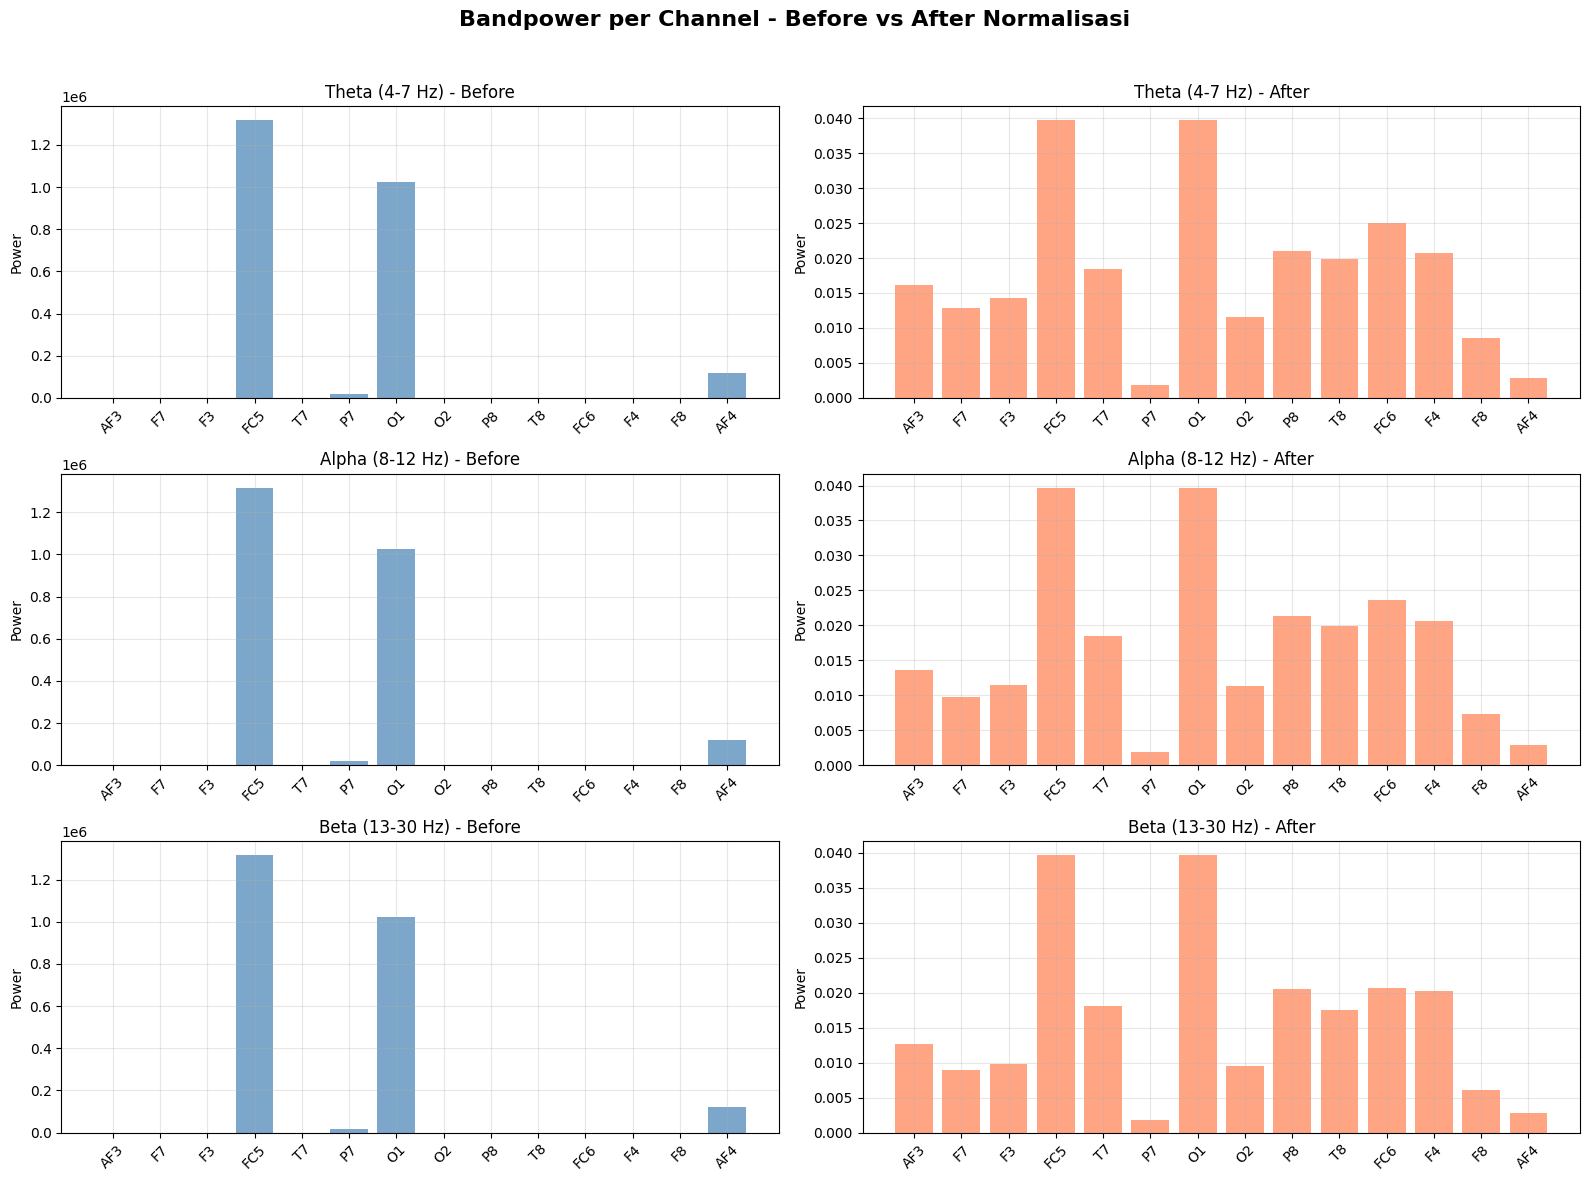

In [97]:
import matplotlib.pyplot as plt

channel_names = psd_before.ch_names
bands = list(bandpower_before.keys())

fig, axes = plt.subplots(len(bands), 2, figsize=(16, 12))
fig.suptitle("Bandpower per Channel - Before vs After Normalisasi", fontsize=16, fontweight='bold')

for i, band in enumerate(bands):
    # Before
    axes[i, 0].bar(channel_names, bandpower_before[band], color='steelblue', alpha=0.7)
    axes[i, 0].set_title(f"{band} - Before")
    axes[i, 0].set_ylabel("Power")
    axes[i, 0].grid(True, alpha=0.3)
    axes[i, 0].tick_params(axis='x', rotation=45)

    # After
    axes[i, 1].bar(channel_names, bandpower_after[band], color='coral', alpha=0.7)
    axes[i, 1].set_title(f"{band} - After")
    axes[i, 1].set_ylabel("Power")
    axes[i, 1].grid(True, alpha=0.3)
    axes[i, 1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # kasih ruang untuk suptitle
plt.show()

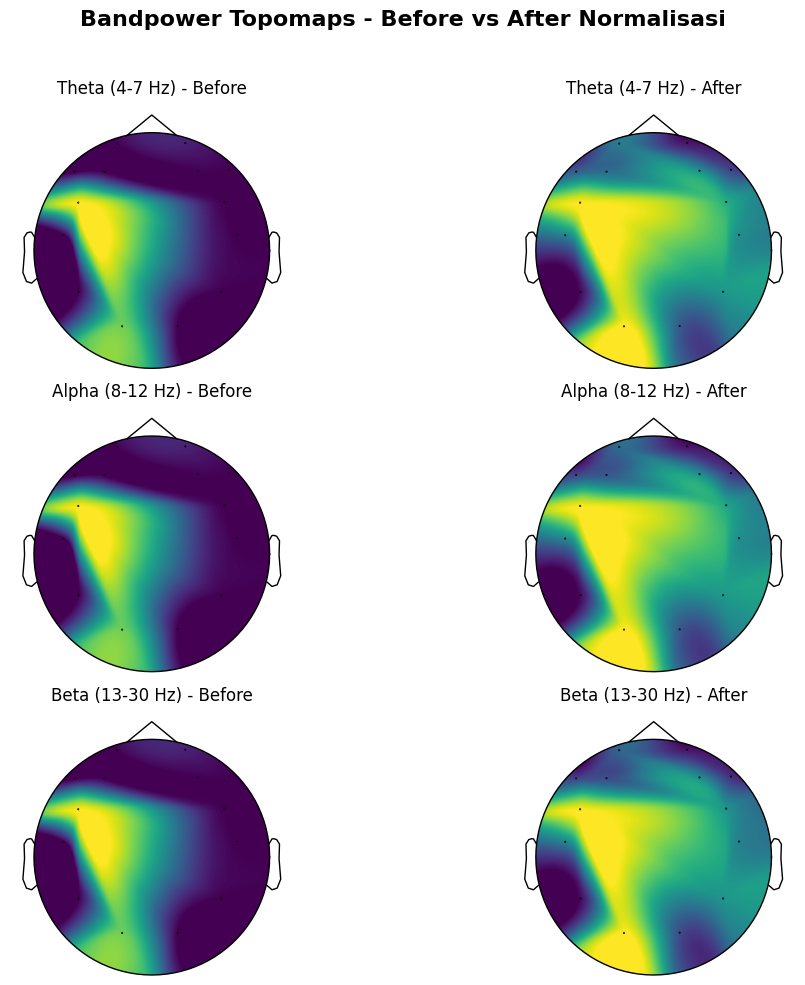

In [98]:
import matplotlib.pyplot as plt
import mne

bands_to_plot = [
    ("Theta (4-7 Hz)", band_indices["Theta (4-7 Hz)"]),
    ("Alpha (8-12 Hz)", band_indices["Alpha (8-12 Hz)"]),
    ("Beta (13-30 Hz)", band_indices["Beta (13-30 Hz)"])
]

fig, axes = plt.subplots(len(bands_to_plot), 2, figsize=(12, 10))
fig.suptitle("Bandpower Topomaps - Before vs After Normalisasi", fontsize=16, fontweight='bold')

for i, (band_name, idxs) in enumerate(bands_to_plot):
    # Before
    band_power_before = psd_data_before[:, idxs].mean(axis=1)
    mne.viz.plot_topomap(
        band_power_before,
        raw_before.info,
        axes=axes[i, 0],
        cmap="viridis",
        contours=0,
        show=False
    )
    axes[i, 0].set_title(f"{band_name} - Before")

    # After
    band_power_after = psd_data_after[:, idxs].mean(axis=1)
    mne.viz.plot_topomap(
        band_power_after,
        raw_after.info,
        axes=axes[i, 1],
        cmap="viridis",
        contours=0,
        show=False
    )
    axes[i, 1].set_title(f"{band_name} - After")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

<h1 style="background-color:#1C64BE; color:white; padding:12px 16px; border-radius:6px;">
Tahap 3: Pengembangan dan Pelatihan Model
</h1>

In [100]:
import numpy as np
from sklearn.model_selection import train_test_split

# gabungkan X0 dan X1
X = np.concatenate([X0_norm, X1_norm], axis=0)

# label: 0 untuk X0, 1 untuk X1
y = np.array([0]*len(X0_norm) + [1]*len(X1_norm))

print("X:", X.shape)
print("y:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

X: (116, 128, 14)
y: (116,)


### Function Plot History dan Evaluate untuk Proses Training 3 Model

In [101]:
import matplotlib.pyplot as plt

def plot_history(history):
    h = history.history
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(h['loss'], label='train_loss')
    plt.plot(h.get('val_loss', []), label='val_loss')
    plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(); plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(h['accuracy'], label='train_acc')
    plt.plot(h.get('val_accuracy', []), label='val_acc')
    plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.legend(); plt.grid(True)
    plt.show()


In [102]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import numpy as np

def evaluate_model(model, X_test, y_test, model_name="Model"):
    """
    Evaluasi model dan return semua metrics
    """
    # Evaluasi akurasi
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

    # Prediksi probabilitas
    y_pred_probs = model.predict(X_test)

    # Binary classification (sigmoid)
    if y_pred_probs.shape[1] == 1 or len(y_pred_probs.shape) == 1:
        y_pred = (y_pred_probs > 0.5).astype(int).flatten()
    # Multi-class (softmax)
    else:
        y_pred = np.argmax(y_pred_probs, axis=1)

    # Hitung metrics
    cm = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')

    # Print hasil
    print(f"\n{'='*50}")
    print(f"EVALUASI {model_name}")
    print(f"{'='*50}")
    print(f"Test Accuracy:     {accuracy:.4f}")
    print(f"Precision:         {precision:.4f}")
    print(f"Recall:            {recall:.4f}")
    print(f"F1-Score:          {f1:.4f}")
    print(f"\nConfusion Matrix:")
    print(cm)
    print(f"{'='*50}\n")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'cm': cm,
        'y_pred': y_pred
    }


<h3 style="background-color:#CE5A08; color:white; padding:4px 8px; border-radius:6px;">
Model 1: LSTM
</h3>

### Cross Validation LSTM

In [ ]:
from sklearn.model_selection import KFold
import numpy as np
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


# Fungsi untuk membuat model dengan parameter variabel

def create_lstm_model(units1=64, units2=32, dropout1=0.4, dropout2=0.4, lr=1e-3):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units1, return_sequences=True, kernel_regularizer=l2(1e-4)),
        Dropout(dropout1),
        LSTM(units2, kernel_regularizer=l2(1e-4)),
        Dropout(dropout2),
        Dense(32, activation='relu', kernel_regularizer=l2(1e-4)),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


# Grid parameter yang mau dicoba

param_grid = [
    {'units1': 64,  'units2': 32,  'dropout1': 0.4, 'dropout2': 0.4, 'lr': 1e-3},
    {'units1': 128, 'units2': 64,  'dropout1': 0.3, 'dropout2': 0.3, 'lr': 5e-4},
    {'units1': 256, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.2, 'lr': 1e-4},
    {'units1': 32,  'units2': 16,  'dropout1': 0.5, 'dropout2': 0.5, 'lr': 2e-3},
]


# Loop CV untuk pilih parameter terbaik

best_score = 0
best_params = None
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for params in param_grid:
    scores = []
    for train_idx, val_idx in kf.split(X_train):
        model = create_lstm_model(**params)
        model.fit(X_train[train_idx], y_train[train_idx],
                  epochs=50, batch_size=8, verbose=0)
        score = model.evaluate(X_train[val_idx], y_train[val_idx], verbose=0)[1]
        scores.append(score)
    mean_score = np.mean(scores)
    print("Params:", params, "Mean CV Accuracy:", mean_score)
    if mean_score > best_score:
        best_score = mean_score
        best_params = params

print("\nModel terbaik berdasarkan CV:", best_params)

Params: {'units1': 64, 'units2': 32, 'dropout1': 0.4, 'dropout2': 0.4, 'lr': 0.001} Mean CV Accuracy: 0.9350877165794372
Params: {'units1': 128, 'units2': 64, 'dropout1': 0.3, 'dropout2': 0.3, 'lr': 0.0005} Mean CV Accuracy: 0.9356725215911865
Params: {'units1': 256, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.2, 'lr': 0.0001} Mean CV Accuracy: 0.9251462101936341
Params: {'units1': 32, 'units2': 16, 'dropout1': 0.5, 'dropout2': 0.5, 'lr': 0.002} Mean CV Accuracy: 0.9678362607955933

Model terbaik berdasarkan CV: {'units1': 32, 'units2': 16, 'dropout1': 0.5, 'dropout2': 0.5, 'lr': 0.002}


### Arsitektur Model LSTM

Model: "sequential_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_80 (LSTM)                  │ (None, 128, 32)        │         6,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_195 (Dropout)           │ (None, 128, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_81 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_196 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_197 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,729 (38.00 KB)

 Trainable params: 9,729 (38.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4249 - loss: 0.7194
Epoch 1: val_loss improved from inf to 0.69493, saving model to lstm.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.4336 - loss: 0.7183 - val_accuracy: 0.5789 - val_loss: 0.6949 - learning_rate: 0.0020
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8171 - loss: 0.6582
Epoch 2: val_loss improved from 0.69493 to 0.67334, saving model to lstm.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8125 - loss: 0.6587 - val_accuracy: 0.5789 - val_loss: 0.6733 - learning_rate: 0.0020
Epoch 3/50
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6935 - loss: 0.6697
Epoch 3: val_loss improved from 0.67334 to 0.63204, saving model to lstm.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6958 - loss: 0.6684 - val_accuracy: 0.6316 - val_loss: 0.6320 - learning_rate: 0.0020
Epoch 4/50
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6993 - loss: 0.6435
Epoch 4: val_loss improved from 0.63204 to 0.59804, saving model to lstm.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7041 - loss: 0.6394 - val_accuracy: 0.6842 - val_loss: 0.5980 - learning_rate: 0.0020
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8246 - loss: 0.5621
Epoch 5: val_loss improved from 0.59804 to 0.54838, saving model to lstm.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8256 - loss: 0.5592 - val_accuracy: 0.7368 - val_loss: 0.5484 - learning_rate: 0.0020
Epoch 6/50
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9048 - loss: 0.4054
Epoch 6: val_loss improved from 0.54838 to 0.34477, saving model to lstm.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9071 - loss: 0.3980 - val_accuracy: 0.8947 - val_loss: 0.3448 - learning_rate: 0.0020
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9131 - loss: 0.3204
Epoch 7: val_loss improved from 0.34477 to 0.27257, saving model to lstm.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9136 - loss: 0.3185 - val_accuracy: 0.9474 - val_loss: 0.2726 - learning_rate: 0.0020
Epoch 8/50
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9862 - loss: 0.1988
Epoch 8: val_loss did not improve from 0.27257
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9862 - loss: 0.1961 - val_accuracy: 0.8947 - val_loss: 0.2786 - learning_rate: 0.0020
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.1507
Epoch 9: val_loss did not improve from 0.27257
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.1505 - val_accuracy: 0.8947 - val_loss: 0.2785 - learning_rate: 0.0020
Epoch 10/50
 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9698 - loss: 0.1373
Epoch 10: val_loss improved from 0.27257 to 0.16963, saving model to lstm.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9767 - loss: 0.1214 - val_accuracy: 0.9474 - val_loss: 0.1696 - learning_rate: 0.0020
Epoch 11/50
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0353
Epoch 11: val_loss did not improve from 0.16963
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.0364 - val_accuracy: 0.9474 - val_loss: 0.2237 - learning_rate: 0.0020
Epoch 12/50
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9947 - loss: 0.0886
Epoch 12: val_loss did not improve from 0.16963
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9932 - loss: 0.0988 - val_accuracy: 0.9474 - val_loss: 0.2601 - learning_rate: 0.0020
Epoch 13/50
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0515
Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.

Epoch 13: val_loss did not improve from 0.16963
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0518 - val_accuracy: 0.9474 - v

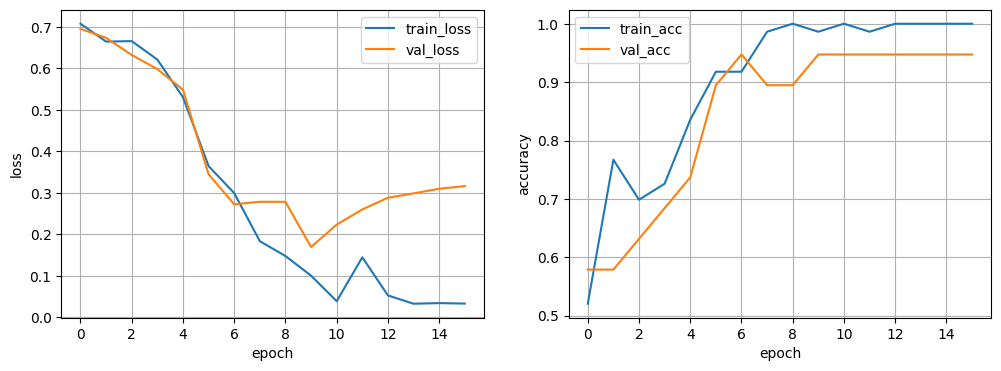

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


# Buat model final pakai parameter terbaik

final_model_lstm = create_lstm_model(**best_params)
final_model_lstm.summary()


# Setup callbacks

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint('lstm.h5', monitor='val_loss', save_best_only=True, verbose=1)
]


# Latih model final

final_model_lstm.compile(optimizer=Adam(learning_rate=best_params['lr']),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

history = final_model_lstm.fit(
    X_train, y_train,
    epochs=50,
    batch_size=8,
    validation_split=0.2,
    callbacks=callbacks,
    shuffle=True
)


# Plot history

plot_history(history)

### Evaluasi Model LSTM

In [106]:
# Evaluasi LSTM - FIX: ganti "model" dengan "final_model"
lstm_results = evaluate_model(final_model_lstm, X_test, y_test, "LSTM")
lstm_acc = lstm_results['accuracy']
lstm_precision = lstm_results['precision']
lstm_recall = lstm_results['recall']
lstm_f1 = lstm_results['f1']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step

EVALUASI LSTM
Test Accuracy:     1.0000
Precision:         1.0000
Recall:            1.0000
F1-Score:          1.0000

Confusion Matrix:
[[14  0]
 [ 0 10]]



<h3 style="background-color:#CE5A08; color:white; padding:4px 8px; border-radius:6px;">
Model 2: CNN
</h3>

### Cross Validation CNN

In [ ]:
from sklearn.model_selection import KFold
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


# Fungsi buat CNN dengan parameter variabel

def create_cnn_model(filters1=32, filters2=64, dropout1=0.4, dropout2=0.4, dense_units=32, lr=1e-3):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        Conv1D(filters1, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
        Dropout(dropout1),
        Conv1D(filters2, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
        Dropout(dropout2),
        GlobalAveragePooling1D(),
        Dense(dense_units, activation='relu', kernel_regularizer=l2(1e-4)),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


# Grid parameter yang mau dicoba

param_grid = [
    {'filters1':32, 'filters2':64, 'dropout1':0.4, 'dropout2':0.4, 'dense_units':32, 'lr':1e-3},
    {'filters1':64, 'filters2':128, 'dropout1':0.3, 'dropout2':0.3, 'dense_units':64, 'lr':5e-4},
    {'filters1':32, 'filters2':128, 'dropout1':0.2, 'dropout2':0.4, 'dense_units':64, 'lr':1e-3},
    {'filters1':64, 'filters2':64, 'dropout1':0.3, 'dropout2':0.2, 'dense_units':32, 'lr':5e-4}
]


# Loop CV untuk pilih parameter terbaik

best_score = 0
best_params = None
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for params in param_grid:
    scores = []
    for train_idx, val_idx in kf.split(X_train):
        model = create_cnn_model(**params)
        model.fit(X_train[train_idx], y_train[train_idx],
                  epochs=50, batch_size=8, verbose=0)
        score = model.evaluate(X_train[val_idx], y_train[val_idx], verbose=0)[1]
        scores.append(score)
    mean_score = np.mean(scores)
    print("Params:", params, "Mean CV Accuracy:", mean_score)
    if mean_score > best_score:
        best_score = mean_score
        best_params = params

print("\nModel CNN terbaik berdasarkan CV:", best_params)

Params: {'filters1': 32, 'filters2': 64, 'dropout1': 0.4, 'dropout2': 0.4, 'dense_units': 32, 'lr': 0.001} Mean CV Accuracy: 0.9783625721931457
Params: {'filters1': 64, 'filters2': 128, 'dropout1': 0.3, 'dropout2': 0.3, 'dense_units': 64, 'lr': 0.0005} Mean CV Accuracy: 0.9783625721931457
Params: {'filters1': 32, 'filters2': 128, 'dropout1': 0.2, 'dropout2': 0.4, 'dense_units': 64, 'lr': 0.001} Mean CV Accuracy: 0.9783625721931457
Params: {'filters1': 64, 'filters2': 64, 'dropout1': 0.3, 'dropout2': 0.2, 'dense_units': 32, 'lr': 0.0005} Mean CV Accuracy: 0.9783625721931457

Model CNN terbaik berdasarkan CV: {'filters1': 32, 'filters2': 64, 'dropout1': 0.4, 'dropout2': 0.4, 'dense_units': 32, 'lr': 0.001}


### Arsitektur Model CNN

Model: "sequential_83"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_84 (Conv1D)              │ (None, 128, 32)        │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_258 (Dropout)           │ (None, 128, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_85 (Conv1D)              │ (None, 128, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_259 (Dropout)           │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_42     │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_175 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_260 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_176 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,697 (37.88 KB)

 Trainable params: 9,697 (37.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.6503 - loss: 0.7128
Epoch 1: val_loss improved from inf to 0.65909, saving model to best_cnn_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 410ms/step - accuracy: 0.6460 - loss: 0.7120 - val_accuracy: 0.8947 - val_loss: 0.6591 - learning_rate: 0.0010
Epoch 2/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8750 - loss: 0.6558
Epoch 2: val_loss improved from 0.65909 to 0.61633, saving model to best_cnn_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8809 - loss: 0.6552 - val_accuracy: 0.8947 - val_loss: 0.6163 - learning_rate: 0.0010
Epoch 3/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7500 - loss: 0.6721
Epoch 3: val_loss improved from 0.61633 to 0.57413, saving model to best_cnn_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8354 - loss: 0.6248 - val_accuracy: 0.9474 - val_loss: 0.5741 - learning_rate: 0.0010
Epoch 4/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 0.5671
Epoch 4: val_loss improved from 0.57413 to 0.52150, saving model to best_cnn_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9510 - loss: 0.5713 - val_accuracy: 0.9474 - val_loss: 0.5215 - learning_rate: 0.0010
Epoch 5/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8750 - loss: 0.5409
Epoch 5: val_loss improved from 0.52150 to 0.44966, saving model to best_cnn_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9654 - loss: 0.4951 - val_accuracy: 0.9474 - val_loss: 0.4497 - learning_rate: 0.0010
Epoch 6/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.3750
Epoch 6: val_loss improved from 0.44966 to 0.37847, saving model to best_cnn_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9890 - loss: 0.3906 - val_accuracy: 0.9474 - val_loss: 0.3785 - learning_rate: 0.0010
Epoch 7/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.2531
Epoch 7: val_loss improved from 0.37847 to 0.32221, saving model to best_cnn_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.2664 - val_accuracy: 0.9474 - val_loss: 0.3222 - learning_rate: 0.0010
Epoch 8/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 1.0000 - loss: 0.1859
Epoch 8: val_loss improved from 0.32221 to 0.29716, saving model to best_cnn_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.1986 - val_accuracy: 0.9474 - val_loss: 0.2972 - learning_rate: 0.0010
Epoch 9/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0777
Epoch 9: val_loss improved from 0.29716 to 0.27767, saving model to best_cnn_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.1271 - val_accuracy: 0.9474 - val_loss: 0.2777 - learning_rate: 0.0010
Epoch 10/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.0481
Epoch 10: val_loss improved from 0.27767 to 0.27461, saving model to best_cnn_model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9767 - loss: 0.0756 - val_accuracy: 0.9474 - val_loss: 0.2746 - learning_rate: 0.0010
Epoch 11/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.0530
Epoch 11: val_loss did not improve from 0.27461
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0664 - val_accuracy: 0.9474 - val_loss: 0.2894 - learning_rate: 0.0010
Epoch 12/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0410
Epoch 12: val_loss did not improve from 0.27461
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0506 - val_accuracy: 0.9474 - val_loss: 0.2953 - learning_rate: 0.0010
Epoch 13/50
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.0470
Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: val_loss did not improve from 0.27461
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0338 - val_accuracy: 0.9474 - val_

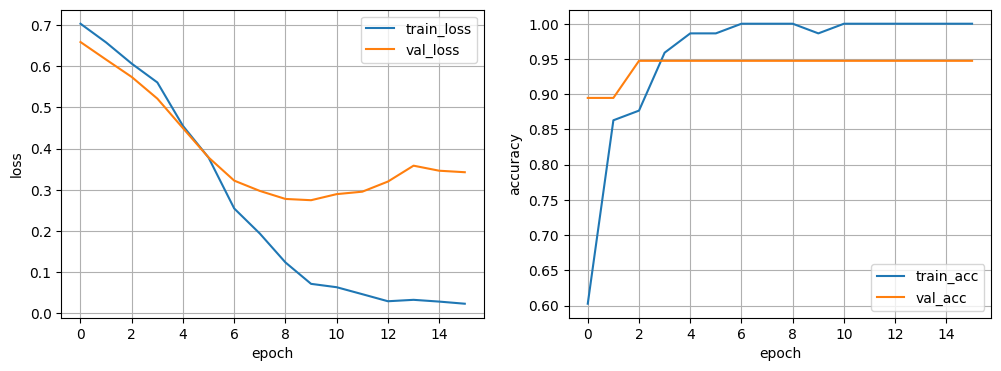

In [ ]:


# Buat model final pakai parameter terbaik

final_model_cnn = create_cnn_model(**best_params)
final_model_cnn.summary()


# Setup callbacks

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_cnn_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]


# Latih model final

history = final_model_cnn.fit(
    X_train, y_train,
    epochs=50,
    batch_size=8,
    validation_split=0.2,
    callbacks=callbacks,
    shuffle=True
)


# Plot history

plot_history(history)

### Evaluasi Model CNN

In [109]:
# Evaluasi CNN
cnn_results = evaluate_model(final_model_cnn, X_test, y_test, "CNN")
cnn_acc = cnn_results['accuracy']
cnn_precision = cnn_results['precision']
cnn_recall = cnn_results['recall']
cnn_f1 = cnn_results['f1']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step

EVALUASI CNN
Test Accuracy:     0.9583
Precision:         1.0000
Recall:            0.9000
F1-Score:          0.9474

Confusion Matrix:
[[14  0]
 [ 1  9]]



<h3 style="background-color:#CE5A08; color:white; padding:4px 8px; border-radius:6px;">
Model 3: EEGNet
</h3>

In [110]:
# Pastikan X_train dan X_test sudah didefinisikan sebelumnya
X_train_r = X_train.transpose(0, 2, 1).reshape((-1, 14, 128, 1))
# y_train_r = X_train.transpose(0, 2, 1).reshape((-1, 14, 128, 1))
X_test_r  = X_test.transpose(0, 2, 1).reshape((-1, 14, 128, 1))
# y_test_r  = X_test.transpose(0, 2, 1).reshape((-1, 14, 128, 1))
print(X_train_r.shape)
print(X_test_r.shape)
print(y_train.shape)
print(y_test.shape)

(92, 14, 128, 1)
(24, 14, 128, 1)
(92,)
(24,)


In [111]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, DepthwiseConv2D, SeparableConv2D,
    BatchNormalization, Activation, AveragePooling2D,
    Dropout, GlobalAveragePooling2D, Dense
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import MaxNorm

def create_eegnet_model(learning_rate=3e-4):
    nb_classes = 2
    Chans = 14
    Samples = 128

    input_layer = Input(shape=(Chans, Samples, 1))

    # ===== Block 1: Temporal Conv (KURANGI) =====
    F1 = 32
    KernLength = 64

    x = Conv2D(F1, (1, KernLength),
               padding='same',
               use_bias=False)(input_layer)
    x = BatchNormalization()(x)

    # ===== Block 2: Spatial Depthwise Conv =====
    D = 2
    x = DepthwiseConv2D((Chans, 1),
                        depth_multiplier=D,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    # ===== Block 3: Separable Conv (ringan) =====
    x = SeparableConv2D(F1 * D, (1, 16),
                        padding='same',
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    # ===== Pooling + Dropout =====
    x = AveragePooling2D((1, 4))(x)
    x = Dropout(0.5)(x)

    # ===== Classifier =====
    x = GlobalAveragePooling2D()(x)
    output = Dense(1, activation='sigmoid',
                   kernel_constraint=MaxNorm(0.25))(x)

    model = Model(inputs=input_layer, outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


### Arsitektur Model EEGNet

Train label distribusi: [40 33]
Val label distribusi  : [10  9]


Model: "functional_93"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_93 (InputLayer)     │ (None, 14, 128, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 128, 32)    │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 14, 128, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_9              │ (None, 1, 128, 64)     │           896 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 1, 128, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 1, 128, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_9              │ (None, 1, 128, 64)     │         5,120 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 1, 128, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 1, 128, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_9             │ (None, 1, 32, 64)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_261 (Dropout)           │ (None, 1, 32, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_177 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,769 (34.25 KB)

 Trainable params: 8,449 (33.00 KB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 421ms/step - accuracy: 0.4680 - loss: 0.7496 - val_accuracy: 0.4737 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8180 - loss: 0.6511 - val_accuracy: 0.5263 - val_loss: 0.6929 - learning_rate: 0.0010
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7257 - loss: 0.6373 - val_accuracy: 0.5263 - val_loss: 0.6925 - learning_rate: 0.0010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8949 - loss: 0.5702 - val_accuracy: 0.5263 - val_loss: 0.6921 - learning_rate: 0.0010
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8785 - loss: 0.5595 - val_accuracy: 0.5263 - val_loss: 0.6918 - learning_rate: 0.0010
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9373 - loss: 0.4935 - val_accuracy: 0.5263 - val_loss: 0.6919 - learning_rate: 0.0010
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9223 - loss: 0.4616 - val_ac

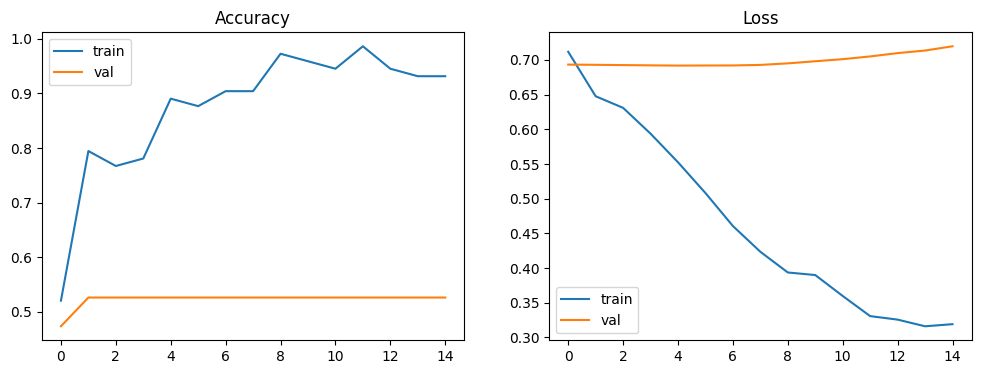

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import numpy as np

# Split the training data into training and validation sets for EEGNet
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_r, y_train,
    test_size=0.2,
    stratify=y_train,   # This is important for balanced classes
    random_state=42
)

print("Train label distribusi:", np.bincount(y_tr))
print("Val label distribusi  :", np.bincount(y_val))

# ======================
# Build model
# ======================
final_eegnet = create_eegnet_model(learning_rate=1e-3)

final_eegnet.summary()

# ======================
# Callbacks (penting biar stabil)
# ======================
callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-5,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
]

# ======================
# Train (tanpa CV)
# ======================
history = final_eegnet.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),  # WAJIB
    epochs=50,
    batch_size=8,
    shuffle=True,
    callbacks=callbacks,
    verbose=1
)

# ======================
# Plot training history
# ======================
def plot_history(history):
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title('Loss')
    plt.legend()

    plt.show()

plot_history(history)


### Analisis Lebih Lanjut: Perbandingan EarlyStopping vs Tidak


EEGNet - WITH EarlyStopping Callback

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 6.

Training berhenti di epoch: 16

EEGNet - WITHOUT EarlyStopping

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 25: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 30: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 35: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 40: ReduceLROnPlateau reducing learning rate to 1e-05.

Training selesai di epoch: 50


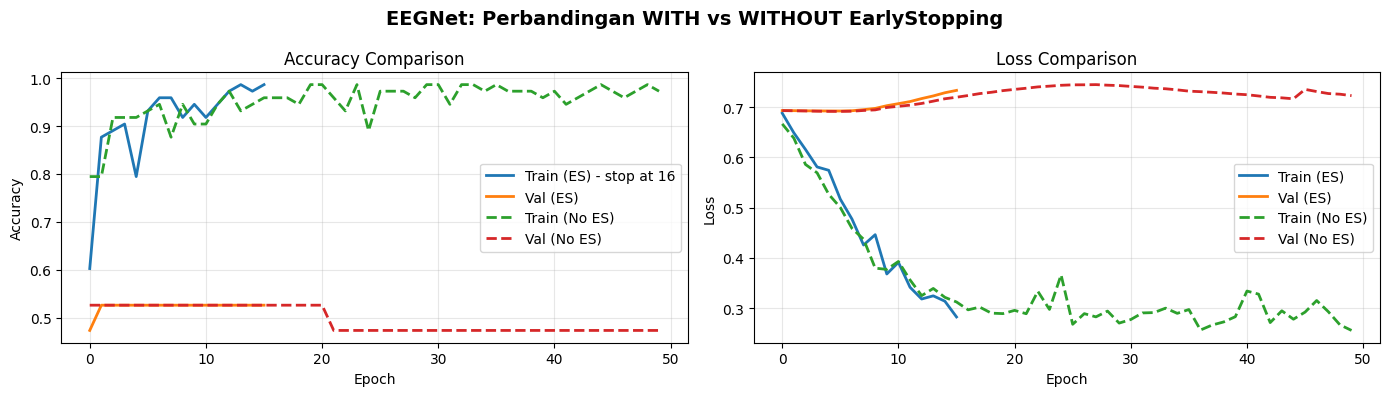


EVALUATION COMPARISON
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

EVALUASI EEGNet (WITH EarlyStopping)
Test Accuracy:     0.5833
Precision:         0.0000
Recall:            0.0000
F1-Score:          0.0000

Confusion Matrix:
[[14  0]
 [10  0]]



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

EVALUASI EEGNet (WITHOUT EarlyStopping)
Test Accuracy:     0.6250
Precision:         1.0000
Recall:            0.1000
F1-Score:          0.1818

Confusion Matrix:
[[14  0]
 [ 9  1]]


              Model  Epochs  Accuracy  Precision  Recall  F1-Score
   EEGNet (WITH ES)      16  0.583333        0.0     0.0  0.000000
EEGNet (WITHOUT ES)     150  0.625000        1.0     0.1  0.181818


In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Version 1: EEGNet DENGAN EarlyStopping

print("\n" + "="*60)
print("EEGNet - WITH EarlyStopping Callback")
print("="*60)

eegnet_with_es = create_eegnet_model(learning_rate=1e-3)

callbacks_with_es = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
]

history_with_es = eegnet_with_es.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=8,
    shuffle=True,
    callbacks=callbacks_with_es,
    verbose=0
)

epochs_with_es = len(history_with_es.history['loss'])
print(f"\nTraining berhenti di epoch: {epochs_with_es}")


# Version 2: EEGNet TANPA EarlyStopping

print("\n" + "="*60)
print("EEGNet - WITHOUT EarlyStopping")
print("="*60)

eegnet_no_es = create_eegnet_model(learning_rate=1e-3)

callbacks_no_es = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)
]

history_no_es = eegnet_no_es.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=8,
    shuffle=True,
    callbacks=callbacks_no_es,
    verbose=0
)

print(f"\nTraining selesai di epoch: 50")


# Visualisasi Perbandingan

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
fig.suptitle("EEGNet: Perbandingan WITH vs WITHOUT EarlyStopping", fontsize=14, fontweight='bold')

# Accuracy
axes[0].plot(history_with_es.history['accuracy'], label=f'Train (ES) - stop at {epochs_with_es}', linewidth=2)
axes[0].plot(history_with_es.history['val_accuracy'], label=f'Val (ES)', linewidth=2)
axes[0].plot(history_no_es.history['accuracy'], label='Train (No ES)', linewidth=2, linestyle='--')
axes[0].plot(history_no_es.history['val_accuracy'], label='Val (No ES)', linewidth=2, linestyle='--')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history_with_es.history['loss'], label=f'Train (ES)', linewidth=2)
axes[1].plot(history_with_es.history['val_loss'], label=f'Val (ES)', linewidth=2)
axes[1].plot(history_no_es.history['loss'], label='Train (No ES)', linewidth=2, linestyle='--')
axes[1].plot(history_no_es.history['val_loss'], label='Val (No ES)', linewidth=2, linestyle='--')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Evaluasi Kedua Version

print("\n" + "="*60)
print("EVALUATION COMPARISON")
print("="*60)

results_with_es = evaluate_model(eegnet_with_es, X_test_r, y_test, "EEGNet (WITH EarlyStopping)")
results_no_es = evaluate_model(eegnet_no_es, X_test_r, y_test, "EEGNet (WITHOUT EarlyStopping)")

# Summary Table
comparison_df = pd.DataFrame({
    'Model': ['EEGNet (WITH ES)', 'EEGNet (WITHOUT ES)'],
    'Epochs': [epochs_with_es, 50],
    'Accuracy': [results_with_es['accuracy'], results_no_es['accuracy']],
    'Precision': [results_with_es['precision'], results_no_es['precision']],
    'Recall': [results_with_es['recall'], results_no_es['recall']],
    'F1-Score': [results_with_es['f1'], results_no_es['f1']]
})

print("\n" + comparison_df.to_string(index=False))

### Analisis Lebih Lanjut: EEGNet Hyperparameter Tuning

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Grid Search: Beberapa Hyperparameter

print("\n" + "="*70)
print("EEGNET HYPERPARAMETER GRID SEARCH")
print("="*70)

hyperparams_grid = [
    {'F1': 16, 'D': 1, 'lr': 1e-3, 'batch_size': 8, 'dropout': 0.3},
    {'F1': 32, 'D': 2, 'lr': 1e-3, 'batch_size': 8, 'dropout': 0.5},
    {'F1': 32, 'D': 2, 'lr': 5e-4, 'batch_size': 8, 'dropout': 0.5},
    {'F1': 64, 'D': 2, 'lr': 1e-3, 'batch_size': 16, 'dropout': 0.5},
    {'F1': 32, 'D': 3, 'lr': 1e-3, 'batch_size': 8, 'dropout': 0.4},
]

def create_eegnet_custom(F1=32, D=2, learning_rate=1e-3, dropout=0.5):
    """EEGNet dengan custom hyperparameters"""
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import (
        Input, Conv2D, DepthwiseConv2D, SeparableConv2D,
        BatchNormalization, Activation, AveragePooling2D,
        Dropout, GlobalAveragePooling2D, Dense
    )
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.constraints import MaxNorm

    Chans = 14
    Samples = 128
    KernLength = 64

    input_layer = Input(shape=(Chans, Samples, 1))

    # Block 1: Temporal Conv
    x = Conv2D(F1, (1, KernLength), padding='same', use_bias=False)(input_layer)
    x = BatchNormalization()(x)

    # Block 2: Spatial Depthwise Conv
    x = DepthwiseConv2D((Chans, 1), depth_multiplier=D, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    # Block 3: Separable Conv
    x = SeparableConv2D(F1 * D, (1, 16), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    # Pooling + Dropout
    x = AveragePooling2D((1, 4))(x)
    x = Dropout(dropout)(x)

    # Classifier
    x = GlobalAveragePooling2D()(x)
    output = Dense(1, activation='sigmoid', kernel_constraint=MaxNorm(0.25))(x)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Grid Search Loop
grid_results = []
histories = {}

for idx, params in enumerate(hyperparams_grid):
    print(f"\n[{idx+1}/{len(hyperparams_grid)}] Training with params: {params}")

    # Create model
    model = create_eegnet_custom(
        F1=params['F1'],
        D=params['D'],
        learning_rate=params['lr'],
        dropout=params['dropout']
    )

    # Callbacks
    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=0),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
    ]

    # Train
    history = model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=params['batch_size'],
        shuffle=True,
        callbacks=callbacks,
        verbose=0
    )

    # Evaluate
    loss, acc = model.evaluate(X_test_r, y_test, verbose=0)
    y_pred_prob = model.predict(X_test_r, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')

    epochs_trained = len(history.history['loss'])

    # Store results
    grid_results.append({
        'Param_Index': idx + 1,
        'F1': params['F1'],
        'D': params['D'],
        'LR': params['lr'],
        'Batch': params['batch_size'],
        'Dropout': params['dropout'],
        'Epochs': epochs_trained,
        'Test_Acc': acc,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })

    histories[idx] = history

    print(f"   -> Test Accuracy: {acc:.4f} | F1: {f1:.4f} | Epochs: {epochs_trained}")

# Create Results DataFrame
results_df = pd.DataFrame(grid_results)
print("\n" + "="*70)
print("GRID SEARCH RESULTS")
print("="*70)
print(results_df.to_string(index=False))

# Find Best Model
best_idx = results_df['Test_Acc'].idxmax()
print(f"\n✓ Best Model (by Test Accuracy): Config #{results_df.loc[best_idx, 'Param_Index']}")
print(results_df.loc[best_idx])


EEGNET HYPERPARAMETER GRID SEARCH

[1/5] Training with params: {'F1': 16, 'D': 1, 'lr': 0.001, 'batch_size': 8, 'dropout': 0.3}
   -> Test Accuracy: 0.6250 | F1: 0.1818 | Epochs: 48

[2/5] Training with params: {'F1': 32, 'D': 2, 'lr': 0.001, 'batch_size': 8, 'dropout': 0.5}


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



   -> Test Accuracy: 0.5833 | F1: 0.0000 | Epochs: 15

[3/5] Training with params: {'F1': 32, 'D': 2, 'lr': 0.0005, 'batch_size': 8, 'dropout': 0.5}


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



   -> Test Accuracy: 0.5833 | F1: 0.0000 | Epochs: 20

[4/5] Training with params: {'F1': 64, 'D': 2, 'lr': 0.001, 'batch_size': 16, 'dropout': 0.5}


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



   -> Test Accuracy: 0.5833 | F1: 0.0000 | Epochs: 17

[5/5] Training with params: {'F1': 32, 'D': 3, 'lr': 0.001, 'batch_size': 8, 'dropout': 0.4}
   -> Test Accuracy: 0.5833 | F1: 0.0000 | Epochs: 14

GRID SEARCH RESULTS
 Param_Index       F1  D     LR  Batch  Dropout  Epochs  Test_Acc  Precision  Recall
           1 0.181818  1 0.0010      8      0.3      48  0.625000        1.0     0.1
           2 0.000000  2 0.0010      8      0.5      15  0.583333        0.0     0.0
           3 0.000000  2 0.0005      8      0.5      20  0.583333        0.0     0.0
           4 0.000000  2 0.0010     16      0.5      17  0.583333        0.0     0.0
           5 0.000000  3 0.0010      8      0.4      14  0.583333        0.0     0.0

✓ Best Model (by Test Accuracy): Config #1
Param_Index     1.000000
F1              0.181818
D               1.000000
LR              0.001000
Batch           8.000000
Dropout         0.300000
Epochs         48.000000
Test_Acc        0.625000
Precision       1.00000

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



### Visualisasi Hasil Analisis Hyperparameter Tuning

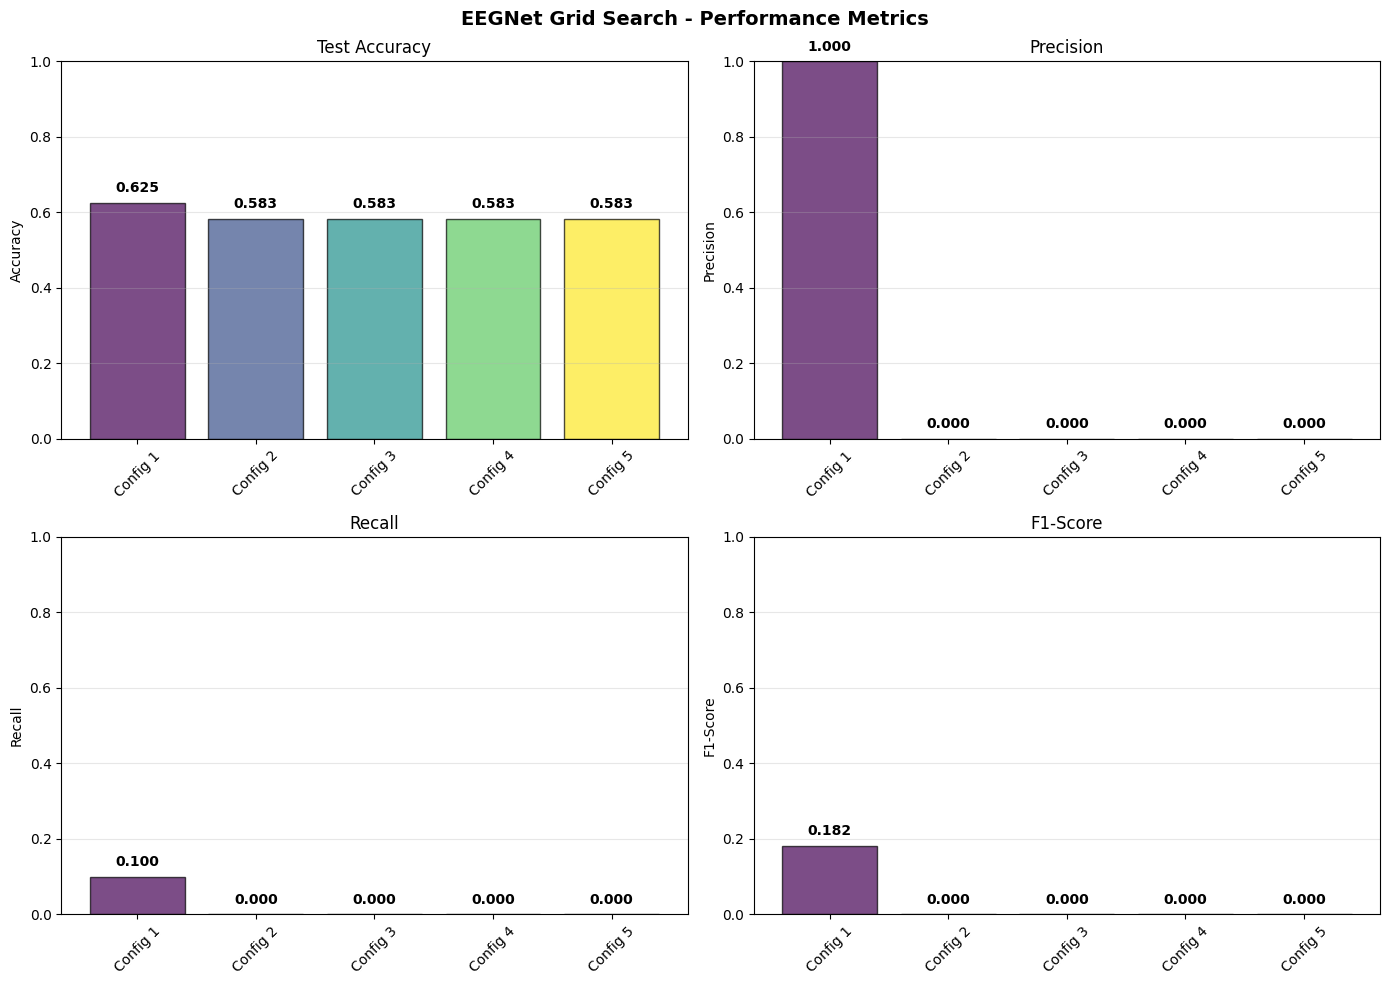

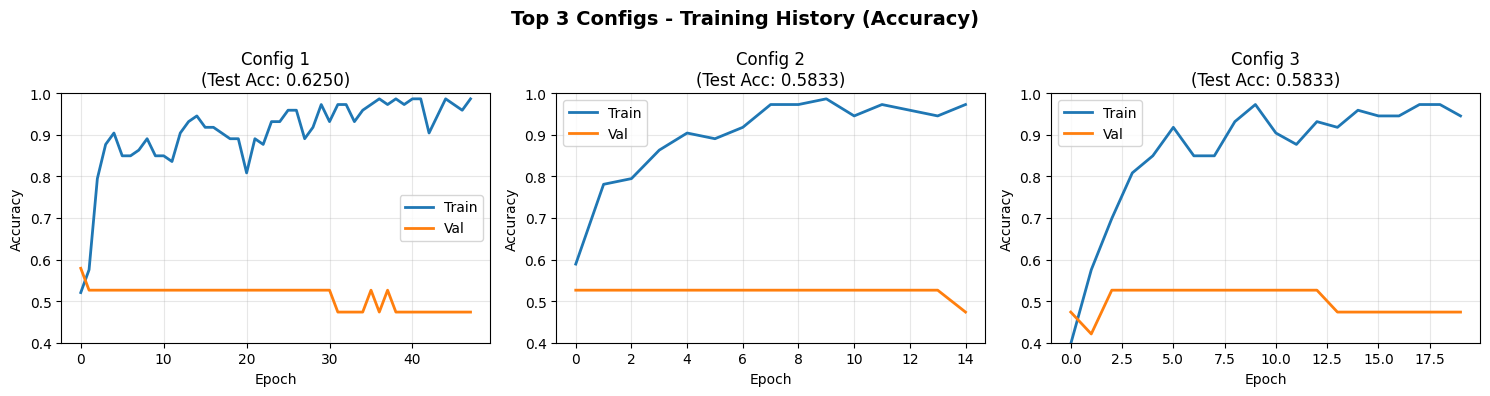

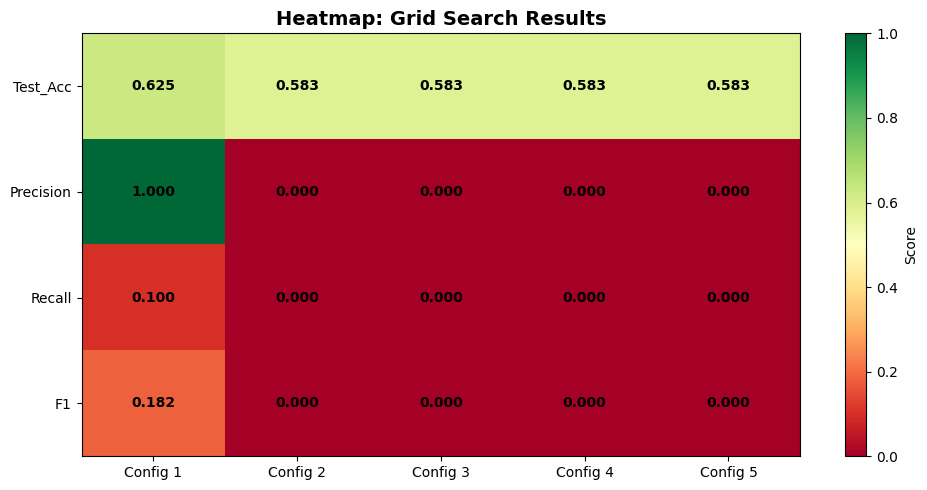


SUMMARY & RECOMMENDATIONS

Results:
  - Test Accuracy: 0.6250
  - Precision: 1.0000
  - Recall: 0.1000
  - F1-Score: 0.1818
  - Epochs trained: 48

Top 3 Configurations:
  1. Config #1 - Acc: 0.6250, F1: 0.1818
  2. Config #2 - Acc: 0.5833, F1: 0.0000
  3. Config #3 - Acc: 0.5833, F1: 0.0000


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Visualisasi 1: Metrik Perbandingan

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('EEGNet Grid Search - Performance Metrics', fontsize=14, fontweight='bold')

configs = [f"Config {i}" for i in results_df['Param_Index']]
colors = plt.cm.viridis(np.linspace(0, 1, len(configs)))

# Test Accuracy
axes[0, 0].bar(configs, results_df['Test_Acc'], color=colors, alpha=0.7, edgecolor='black')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Test Accuracy')
axes[0, 0].set_ylim([0, 1])
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(results_df['Test_Acc']):
    axes[0, 0].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Precision
axes[0, 1].bar(configs, results_df['Precision'], color=colors, alpha=0.7, edgecolor='black')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision')
axes[0, 1].set_ylim([0, 1])
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(results_df['Precision']):
    axes[0, 1].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Recall
axes[1, 0].bar(configs, results_df['Recall'], color=colors, alpha=0.7, edgecolor='black')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].set_title('Recall')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(results_df['Recall']):
    axes[1, 0].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# F1-Score
axes[1, 1].bar(configs, results_df['F1'], color=colors, alpha=0.7, edgecolor='black')
axes[1, 1].set_ylabel('F1-Score')
axes[1, 1].set_title('F1-Score')
axes[1, 1].set_ylim([0, 1])
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(results_df['F1']):
    axes[1, 1].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

for ax in axes.flat:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# Visualisasi 2: Training Comparison (Top 3)

top_3_indices = results_df.nlargest(3, 'Test_Acc').index.tolist()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Top 3 Configs - Training History (Accuracy)', fontsize=14, fontweight='bold')

for i, idx in enumerate(top_3_indices):
    config = results_df.loc[idx, 'Param_Index']
    history = histories[idx]

    axes[i].plot(history.history['accuracy'], label='Train', linewidth=2)
    axes[i].plot(history.history['val_accuracy'], label='Val', linewidth=2)
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Accuracy')

    acc = results_df.loc[idx, 'Test_Acc']
    axes[i].set_title(f"Config {config}\n(Test Acc: {acc:.4f})")
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    axes[i].set_ylim([0.4, 1])

plt.tight_layout()
plt.show()


# Visualisasi 3: Heatmap Parameter Impact

fig, ax = plt.subplots(figsize=(10, 5))

# Prepare data untuk heatmap (Config vs Metrics)
heatmap_data = results_df[['Param_Index', 'Test_Acc', 'Precision', 'Recall', 'F1']].set_index('Param_Index').T

im = ax.imshow(heatmap_data.values, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

ax.set_xticks(range(len(heatmap_data.columns)))
ax.set_yticks(range(len(heatmap_data.index)))
ax.set_xticklabels([f"Config {i}" for i in heatmap_data.columns])
ax.set_yticklabels(heatmap_data.index)

# Tambah nilai di setiap cell
for i in range(len(heatmap_data.index)):
    for j in range(len(heatmap_data.columns)):
        text = ax.text(j, i, f'{heatmap_data.values[i, j]:.3f}',
                      ha="center", va="center", color="black", fontweight='bold')

ax.set_title('Heatmap: Grid Search Results', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax, label='Score')
plt.tight_layout()
plt.show()


# Summary Recommendation

print("\n" + "="*70)
print("SUMMARY & RECOMMENDATIONS")
print("="*70)

best_row = results_df.loc[best_idx]
print(f"\nResults:")
print(f"  - Test Accuracy: {best_row['Test_Acc']:.4f}")
print(f"  - Precision: {best_row['Precision']:.4f}")
print(f"  - Recall: {best_row['Recall']:.4f}")
print(f"  - F1-Score: {best_row['F1']:.4f}")
print(f"  - Epochs trained: {int(best_row['Epochs'])}")

print("\nTop 3 Configurations:")
for rank, idx in enumerate(results_df.nlargest(3, 'Test_Acc').index, 1):
    row = results_df.loc[idx]
    print(f"  {rank}. Config #{int(row['Param_Index'])} - Acc: {row['Test_Acc']:.4f}, F1: {row['F1']:.4f}")

### Evaluasi Model EEGNet

In [124]:
# Prediksi (multi-class EEGNet)
y_pred_prob = final_eegnet.predict(X_test_r)

# Ambil kelas dengan probabilitas tertinggi (argmax)
y_pred = np.argmax(y_pred_prob, axis=1)

# Jika y_test one-hot, ubah ke integer
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

# Hitung metrik
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

eegnet_results = {
    'accuracy': accuracy_score(y_true, y_pred),
    'precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
    'recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
    'f1': f1_score(y_true, y_pred, average='weighted', zero_division=0)
}

# Print hasil evaluasi
print("==================================================")
print("EVALUASI EEGNet")
print("==================================================")
print(f"Test Accuracy:     {eegnet_results['accuracy']:.4f}")
print(f"Precision:         {eegnet_results['precision']:.4f}")
print(f"Recall:            {eegnet_results['recall']:.4f}")
print(f"F1-Score:          {eegnet_results['f1']:.4f}")

# Ambil masing-masing metrik ke variabel lama
eegnet_acc = eegnet_results['accuracy']
eegnet_precision = eegnet_results['precision']
eegnet_recall = eegnet_results['recall']
eegnet_f1 = eegnet_results['f1']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
EVALUASI EEGNet
Test Accuracy:     0.5833
Precision:         0.3403
Recall:            0.5833
F1-Score:          0.4298


# Perbandingan 3 Model

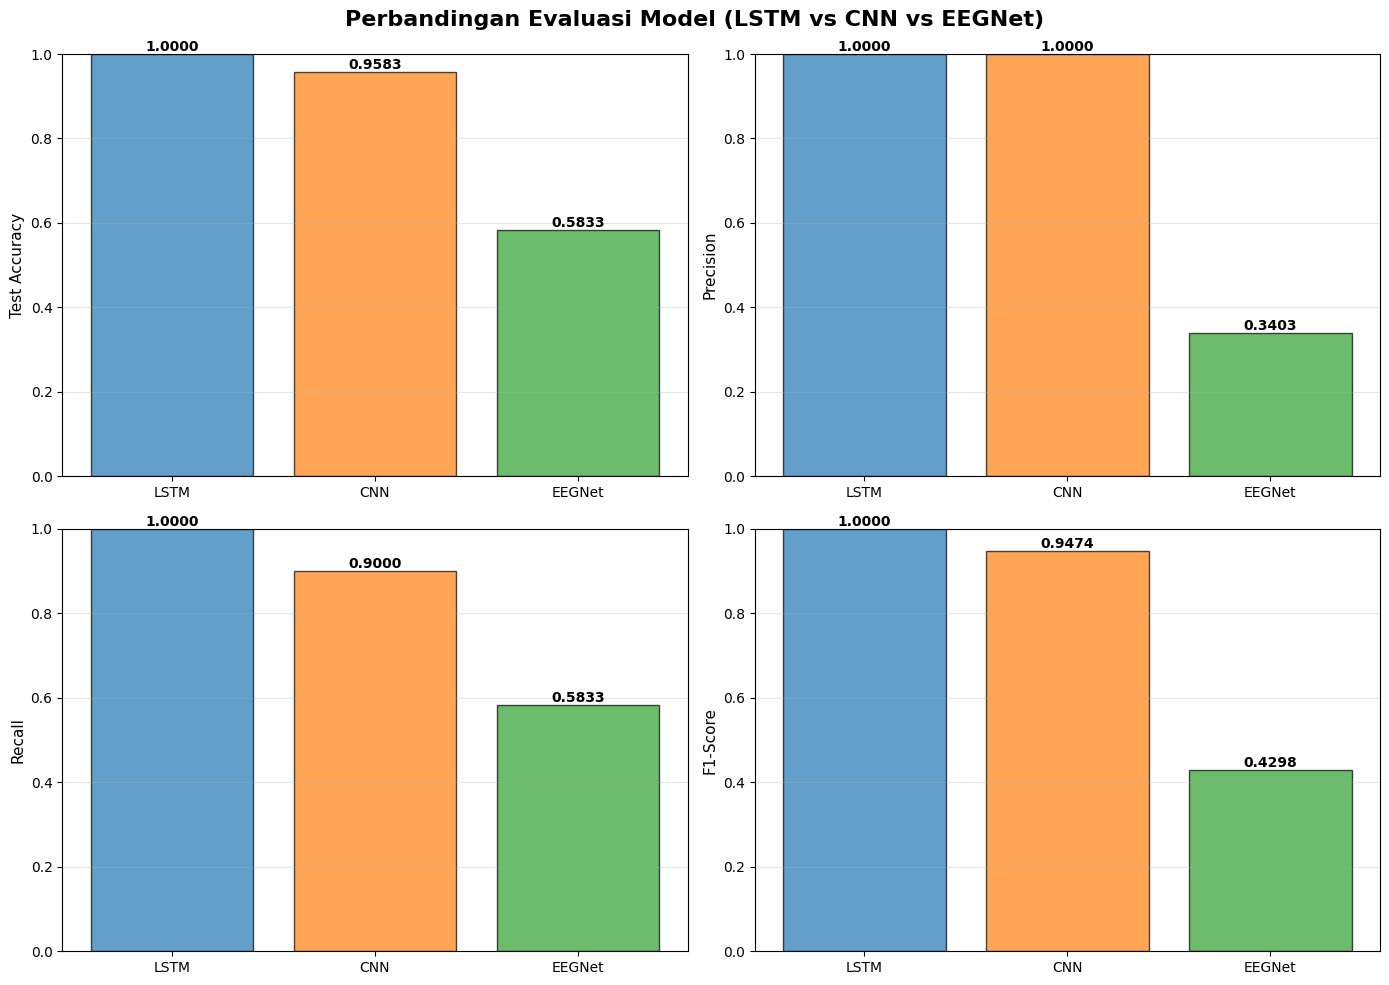

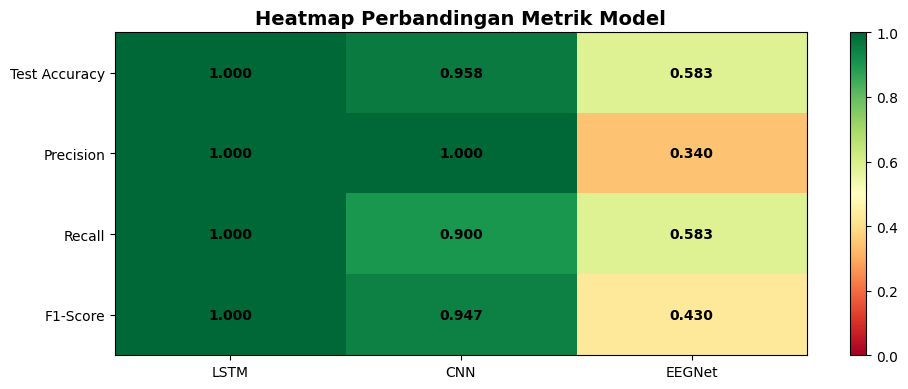

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Simpan hasil evaluasi ketiga model
results = {
    'Model': ['LSTM', 'CNN', 'EEGNet'],
    'Test Accuracy': [lstm_acc, cnn_acc, eegnet_acc],
    'Precision': [lstm_precision, cnn_precision, eegnet_precision],
    'Recall': [lstm_recall, cnn_recall, eegnet_recall],
    'F1-Score': [lstm_f1, cnn_f1, eegnet_f1]
}

df_results = pd.DataFrame(results)

# Visualisasi perbandingan
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Perbandingan Evaluasi Model (LSTM vs CNN vs EEGNet)', fontsize=16, fontweight='bold')

metrics = ['Test Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, (ax, metric) in enumerate(zip(axes.flat, metrics)):
    values = df_results[metric].values
    bars = ax.bar(df_results['Model'], values, color=colors, alpha=0.7, edgecolor='black')
    ax.set_ylabel(metric, fontsize=11)
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3, axis='y')

    # Tambah nilai di atas bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Heatmap perbandingan
fig, ax = plt.subplots(figsize=(10, 4))
metrics_data = df_results.set_index('Model').T
im = ax.imshow(metrics_data.values, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

ax.set_xticks(range(len(metrics_data.columns)))
ax.set_yticks(range(len(metrics_data.index)))
ax.set_xticklabels(metrics_data.columns)
ax.set_yticklabels(metrics_data.index)

for i in range(len(metrics_data.index)):
    for j in range(len(metrics_data.columns)):
        text = ax.text(j, i, f'{metrics_data.values[i, j]:.3f}',
                      ha="center", va="center", color="black", fontweight='bold')

ax.set_title('Heatmap Perbandingan Metrik Model', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()